In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
# Define transforms for training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/train', transform=transform)
val_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
vgg16 = models.vgg16(weights=True)

# for param in vgg16.parameters():
#    param.requires_grad = False

num_classes = len(train_dataset.classes)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg16 = vgg16.to(device)

C:\Users\cnky2\anaconda3\envs\manu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [4]:
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of trainable parameters: 134272835


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001, weight_decay=0.001)

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Training phase
    vgg16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_bar = tqdm(train_loader, desc="Training")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_bar.set_postfix(loss=running_loss / total_train, accuracy=train_accuracy)

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation phase
    vgg16.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_accuracy = 100 * correct_val / total_val
            val_bar.set_postfix(loss=val_loss / total_val, accuracy=val_accuracy)

    # Calculate average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {avg_train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {avg_val_accuracy:.2f}%")

Epoch [1/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.53it/s, accuracy=64.6, loss=0.0264]


Epoch [1/30] - Train Loss: 0.8440, Train Accuracy: 64.61%, Val Loss: 0.7656, Val Accuracy: 69.73%
Epoch [2/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=77.7, loss=0.0193]


Epoch [2/30] - Train Loss: 0.6175, Train Accuracy: 77.73%, Val Loss: 0.6550, Val Accuracy: 74.24%
Epoch [3/30]


Training: 100%|████████████████████████████████████████████| 127/127 [01:23<00:00,  1.53it/s, accuracy=81, loss=0.0167]


Epoch [3/30] - Train Loss: 0.5350, Train Accuracy: 80.97%, Val Loss: 0.5851, Val Accuracy: 76.01%
Epoch [4/30]


Training: 100%|████████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=82, loss=0.0152]


Epoch [4/30] - Train Loss: 0.4853, Train Accuracy: 82.03%, Val Loss: 0.5329, Val Accuracy: 79.07%
Epoch [5/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:24<00:00,  1.51it/s, accuracy=84.6, loss=0.0137]


Epoch [5/30] - Train Loss: 0.4387, Train Accuracy: 84.62%, Val Loss: 0.4970, Val Accuracy: 80.19%
Epoch [6/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=85.5, loss=0.0129]


Epoch [6/30] - Train Loss: 0.4127, Train Accuracy: 85.53%, Val Loss: 0.4665, Val Accuracy: 81.32%
Epoch [7/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.51it/s, accuracy=86.7, loss=0.0122]


Epoch [7/30] - Train Loss: 0.3919, Train Accuracy: 86.68%, Val Loss: 0.4412, Val Accuracy: 83.41%
Epoch [8/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=87.5, loss=0.0114]


Epoch [8/30] - Train Loss: 0.3649, Train Accuracy: 87.47%, Val Loss: 0.4214, Val Accuracy: 84.86%
Epoch [9/30]


Training: 100%|███████████████████████████████████████████| 127/127 [01:22<00:00,  1.53it/s, accuracy=88.6, loss=0.011]


Epoch [9/30] - Train Loss: 0.3511, Train Accuracy: 88.63%, Val Loss: 0.4038, Val Accuracy: 85.67%
Epoch [10/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=87.8, loss=0.0106]


Epoch [10/30] - Train Loss: 0.3405, Train Accuracy: 87.84%, Val Loss: 0.3843, Val Accuracy: 86.15%
Epoch [11/30]


Training: 100%|████████████████████████████████████████████| 127/127 [01:23<00:00,  1.53it/s, accuracy=89.4, loss=0.01]


Epoch [11/30] - Train Loss: 0.3206, Train Accuracy: 89.39%, Val Loss: 0.3695, Val Accuracy: 86.80%
Epoch [12/30]


Training: 100%|████████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=88.9, loss=0.01]


Epoch [12/30] - Train Loss: 0.3206, Train Accuracy: 88.85%, Val Loss: 0.3564, Val Accuracy: 87.76%
Epoch [13/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.54it/s, accuracy=89.1, loss=0.00957]


Epoch [13/30] - Train Loss: 0.3061, Train Accuracy: 89.10%, Val Loss: 0.3425, Val Accuracy: 88.57%
Epoch [14/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=89.5, loss=0.00935]


Epoch [14/30] - Train Loss: 0.2992, Train Accuracy: 89.54%, Val Loss: 0.3362, Val Accuracy: 88.57%
Epoch [15/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.53it/s, accuracy=90.6, loss=0.00879]


Epoch [15/30] - Train Loss: 0.2813, Train Accuracy: 90.62%, Val Loss: 0.3215, Val Accuracy: 88.89%
Epoch [16/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:24<00:00,  1.51it/s, accuracy=90.4, loss=0.00887]


Epoch [16/30] - Train Loss: 0.2838, Train Accuracy: 90.35%, Val Loss: 0.3138, Val Accuracy: 89.69%
Epoch [17/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=90.9, loss=0.00852]


Epoch [17/30] - Train Loss: 0.2725, Train Accuracy: 90.94%, Val Loss: 0.3075, Val Accuracy: 89.21%
Epoch [18/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.53it/s, accuracy=90.8, loss=0.00842]


Epoch [18/30] - Train Loss: 0.2693, Train Accuracy: 90.82%, Val Loss: 0.2982, Val Accuracy: 90.02%
Epoch [19/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.53it/s, accuracy=91.1, loss=0.00804]


Epoch [19/30] - Train Loss: 0.2574, Train Accuracy: 91.09%, Val Loss: 0.2887, Val Accuracy: 90.82%
Epoch [20/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.53it/s, accuracy=91.5, loss=0.00809]


Epoch [20/30] - Train Loss: 0.2590, Train Accuracy: 91.53%, Val Loss: 0.2819, Val Accuracy: 90.02%
Epoch [21/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.53it/s, accuracy=91.6, loss=0.00793]


Epoch [21/30] - Train Loss: 0.2535, Train Accuracy: 91.56%, Val Loss: 0.2767, Val Accuracy: 90.98%
Epoch [22/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.53it/s, accuracy=91.7, loss=0.00761]


Epoch [22/30] - Train Loss: 0.2434, Train Accuracy: 91.71%, Val Loss: 0.2702, Val Accuracy: 91.63%
Epoch [23/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.53it/s, accuracy=92.4, loss=0.00753]


Epoch [23/30] - Train Loss: 0.2410, Train Accuracy: 92.37%, Val Loss: 0.2595, Val Accuracy: 91.63%
Epoch [24/30]


Training: 100%|██████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=92.3, loss=0.0075]


Epoch [24/30] - Train Loss: 0.2401, Train Accuracy: 92.30%, Val Loss: 0.2594, Val Accuracy: 91.63%
Epoch [25/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.53it/s, accuracy=92.1, loss=0.00751]


Epoch [25/30] - Train Loss: 0.2401, Train Accuracy: 92.10%, Val Loss: 0.2498, Val Accuracy: 92.11%
Epoch [26/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.54it/s, accuracy=92.6, loss=0.00709]


Epoch [26/30] - Train Loss: 0.2268, Train Accuracy: 92.64%, Val Loss: 0.2434, Val Accuracy: 92.27%
Epoch [27/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=92.8, loss=0.00704]


Epoch [27/30] - Train Loss: 0.2254, Train Accuracy: 92.76%, Val Loss: 0.2434, Val Accuracy: 92.11%
Epoch [28/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.54it/s, accuracy=93.4, loss=0.00674]


Epoch [28/30] - Train Loss: 0.2155, Train Accuracy: 93.40%, Val Loss: 0.2355, Val Accuracy: 92.59%
Epoch [29/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:22<00:00,  1.55it/s, accuracy=93.2, loss=0.00682]


Epoch [29/30] - Train Loss: 0.2182, Train Accuracy: 93.18%, Val Loss: 0.2315, Val Accuracy: 92.43%
Epoch [30/30]


Training: 100%|█████████████████████████████████████████| 127/127 [01:23<00:00,  1.52it/s, accuracy=92.8, loss=0.00693]
                                                                                                                       

Epoch [30/30] - Train Loss: 0.2217, Train Accuracy: 92.84%, Val Loss: 0.2256, Val Accuracy: 93.24%


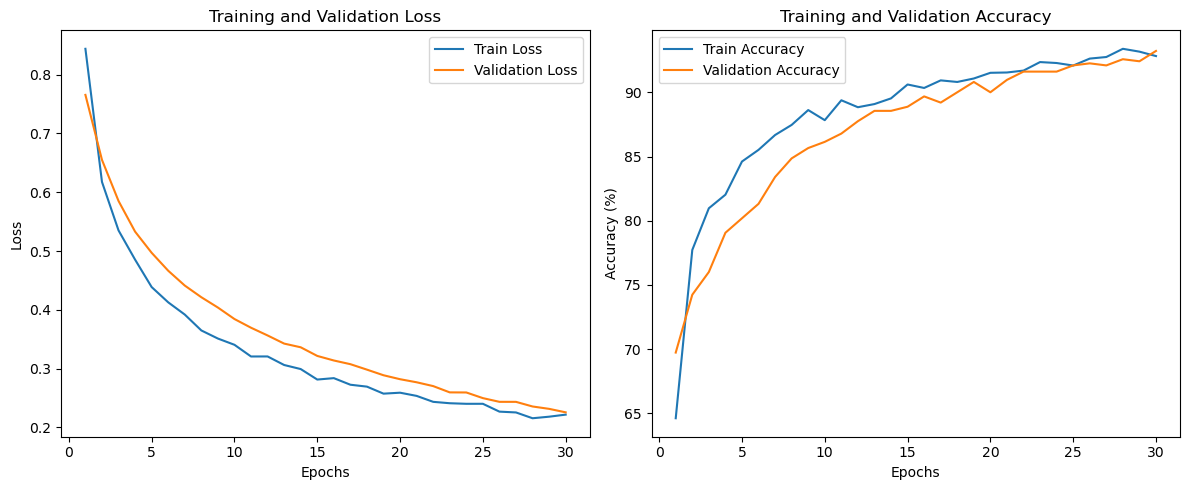

In [7]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()